In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
drive.mount("/content/gdrive", force_remount=True)

In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Git_rep/my_version/leo_segmentation')
import sys, os, argparse, gc, time, numpy as np, tensorflow as tf, pandas as pd
os.chdir(os.path.join("./leo_segmentation"))
from data_pytorch_pascal import Datagenerator, TrainingStats
from leo_fomaml_latest import LEO, load_model, save_model
from utils import load_config, check_experiment, get_named_dict, \
                        log_data, load_yaml, train_logger, val_logger, print_to_string_io, \
                        save_pickled_data, model_dir, list_to_tensor, numpy_to_tensor, prepare_inputs,\
                        tensor_to_numpy
os.chdir('/content/gdrive/MyDrive/Git_rep/my_version/leo_segmentation')
from run import train_model
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
dataset = "pascal_5i_fold_0"
config = load_config()

## Train Model

In [ ]:
leo = train_model(config, dataset)

## Evaluation

In [4]:
mode = "meta_val"
dataset ="fss1000"
dataloader = Datagenerator(config, dataset, data_type=mode)
img_transformer = dataloader.transform_image
mask_transformer = dataloader.transform_mask
transformers = (img_transformer, mask_transformer)
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[4]
print(f"classes in mode {mode}: {class_in_metadata}")

classes in mode meta_val: ['pepitas', 'school_bus', 'sandbar', 'rose', 'sea_urchin']


In [13]:
select_class = 1
pred_data_index = list(range(5))
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class school_bus is selected


In [14]:
#perform forward_propagate and perform innerloop updates to generate weights
seg_weight_grad, features = leo.leo_inner_loop(batch_data.tr_imgs, batch_data.tr_masks)
#fine tune the weights
tr_val_loss, seg_weight_grad, decoder_grads, mean_iou, weight = \
            leo.finetuning_inner_loop(batch_data, features, seg_weight_grad, transformers, mode)

#prepare validation set
if type(pred_data_index) == list:
    input_embedding = np.vstack([list_to_tensor(batch_data.val_imgs[i], img_transformer) \
                                 for i in pred_data_index])
    input_mask = np.vstack([list_to_tensor(batch_data.val_masks[i], mask_transformer) \
                            for i in pred_data_index])
else:
    input_embedding = list_to_tensor(batch_data.val_imgs[pred_data_index], img_transformer)
    input_mask = list_to_tensor(batch_data.val_masks[pred_data_index], mask_transformer)

input_embedding_for_plot = input_embedding.copy()
input_mask_for_plot = input_mask.copy()

input_embedding = prepare_inputs(numpy_to_tensor(input_embedding))
input_mask = numpy_to_tensor(input_mask)
#predict on training data
skip_features = leo.forward_encoder(input_embedding)
features = leo.forward_decoder(skip_features)
val_prediction = leo.forward_segnetwork(features, input_embedding, weight)
val_prediction = np.argmax(tensor_to_numpy(val_prediction), 1)

8it [00:00, 27.12it/s]


In [15]:
def plot_batch_mask(embeds, preds, masks):
    fig = plt.figure(figsize=(20,16))
    for i in range(0, len(preds)):
        embed = np.squeeze(embeds) if len(embeds) == 1 else embeds[i]
        pred = np.squeeze(preds) if len(preds) == 1 else preds[i]
        mask = np.squeeze(masks) if len(masks) == 1 else masks[i]
        
        fig.add_subplot(len(preds), 3, i*3+1)
        plt.imshow((embed+1)/2)
        plt.title("raw images")
        
        fig.add_subplot(len(preds), 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("ground_truth")
        
        fig.add_subplot(len(preds), 3, i*3+3)
        plt.imshow(pred, cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

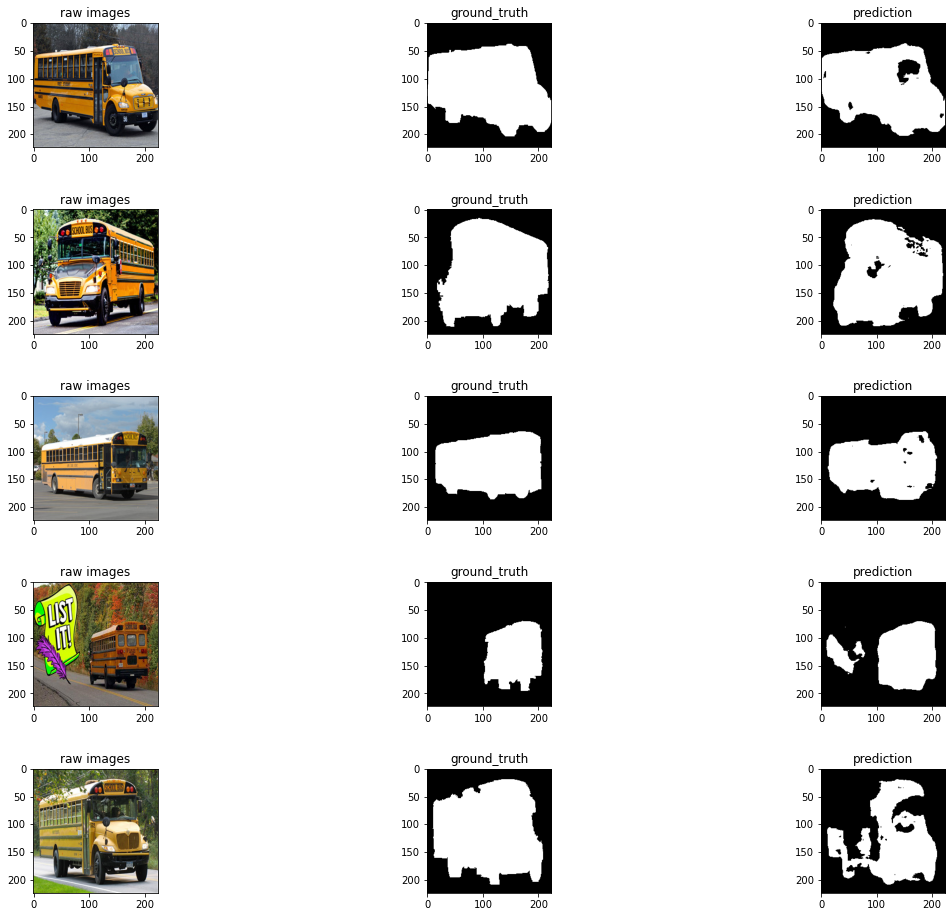

In [16]:
plot_batch_mask(input_embedding_for_plot, val_prediction, input_mask_for_plot)

In [17]:
experiment_number = config.experiment.number
experiment_description = config.experiment.description
experiment_root_path = os.path.join("leo_segmentation", "data", "models", f"experiment_{experiment_number}")
cached_files = os.listdir(experiment_root_path)
cached_files

['experiment_meta_test_11_ious.pkl',
 'experiment_meta_test_11_stats.pkl',
 'experiment_meta_train_11_ious.pkl',
 'experiment_meta_train_11_stats.pkl',
 'experiment_meta_val_11_ious.pkl',
 'experiment_meta_val_11_stats.pkl',
 'train_log.txt',
 'val_log.txt']

In [19]:
filename = cached_files[4]
val_ious = pd.read_pickle(os.path.join(experiment_root_path, filename)).T
print(f"filename: {filename}")
filtered_scores = []
for _class, _df in val_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_val_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_val_ious", "class_sampling_frequency"])
filtered_val_ious = filtered_val_ious.sort_values(by="mean_val_ious", ascending=False)
filtered_val_ious[filtered_val_ious.mean_val_ious > 0.7].count()
filtered_val_ious

filename: experiment_meta_val_11_ious.pkl


,classes,mean_val_ious,class_sampling_frequency
83,rubick_cube,0.892771,29
48,ringlet_butterfly,0.891844,36
159,sealion,0.879872,27
195,pinecone,0.871816,22
100,polar_bear,0.868767,29
193,raven,0.868353,24
78,pickup,0.866202,27
118,seal,0.863465,31
138,pumpkin,0.858142,25
145,skull,0.853734,21


In [ ]:
os.listdir("leo_segmentation/data/fss1000/images")[600:800]

In [ ]:
filtered_val_ious.class_sampling_frequency.max()

In [ ]:
train_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[2])).T
filtered_scores = []
for _class, _df in train_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_train_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_train_ious", "class_sampling_frequency"])
filtered_train_ious = filtered_train_ious.sort_values(by="mean_train_ious", ascending=False)

In [ ]:
#classes in meta-train and meta-val are unique if their intersection is zero
set(filtered_train_ious.classes.unique()).intersection(set(filtered_val_ious.classes.unique()))

In [ ]:
meta_val_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[5]))
meta_train_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[3]))
num_data_points = meta_val_loss.shape[0]

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.title("meta_losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(num_data_points), meta_val_loss.total_val_loss, label="meta_val_loss")
plt.plot(np.arange(num_data_points), meta_train_loss.total_val_loss, label="meta_train_loss")
plt.legend()

In [9]:
results_path = "leo_segmentation/data/models/experiment_15"
cached_files = os.listdir(results_path)
cached_files = {i:k for i,k in enumerate(cached_files)}
cached_files

{0: 'experiment_meta_test_15_ious.pkl',
 1: 'experiment_meta_test_15_stats.pkl',
 2: 'experiment_meta_train_15_ious.pkl',
 3: 'experiment_meta_train_15_stats.pkl',
 4: 'experiment_meta_val_15_ious.pkl',
 5: 'experiment_meta_val_15_stats.pkl',
 6: 'train_log.txt',
 7: 'val_log.txt'}

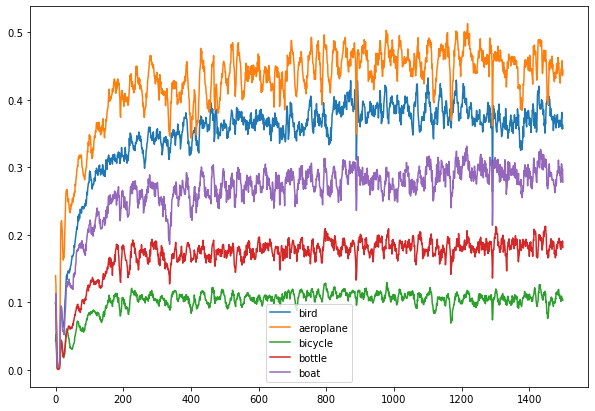

In [18]:
result_df = pd.read_pickle(os.path.join(results_path, cached_files[4]))
fig = plt.figure(figsize=(10, 7))
for i in range(5):
    plt.plot(result_df.iloc[:,i], label=result_df.columns[i])
plt.legend()

In [29]:
train_results_df = pd.read_pickle(os.path.join(results_path, cached_files[2]))
train_results_df.fillna(0.0).max().sort_values(ascending=False)

episode        1500.000000
bus               0.893959
cat               0.873445
dog               0.860753
traine            0.857614
sheep             0.857238
car               0.843671
cow               0.836560
horse             0.793074
motorbike         0.747992
tvmonitor         0.707020
sofa              0.694432
diningtable       0.648596
pottedplant       0.515130
person            0.481221
chair             0.394970
dtype: float64

In [35]:
counts_per_col={}
for i in range(len(train_results_df.columns)):
    if train_results_df.columns[i] == "episode":
        continue
    temp = train_results_df.iloc[:,i]
    temp = temp.dropna()
    counts_per_col[train_results_df.columns[i]] = len(temp)
pd.Series(counts_per_col).sort_values(ascending=False)

chair          538
sheep          520
cat            519
horse          508
bus            504
diningtable    503
person         501
car            496
motorbike      495
pottedplant    493
dog            490
cow            486
sofa           483
tvmonitor      474
traine         464
dtype: int64

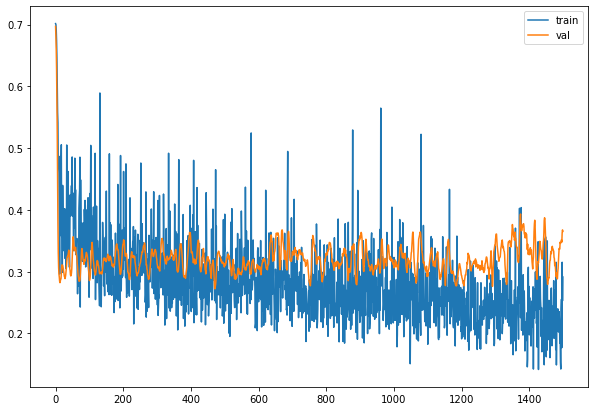

In [43]:
fig = plt.figure(figsize=(10, 7))
plt.plot(pd.read_pickle(os.path.join(results_path,
            cached_files[3]))["total_val_loss"], label="train")
plt.plot(pd.read_pickle(os.path.join(results_path,
            cached_files[5]))["total_val_loss"], label="val")
plt.legend()